In [2]:
# !pip install neuralforecast
# !pip install mlforecast
# !pip install statsforecast

In [148]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean, ExpandingStd
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import warnings
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import time
import os
from mlforecast.target_transforms import Differences
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [56]:
# df = pd.read_csv('data_new/AzureFunctionsInvocationTraceForTwoWeeksJan2021.txt')
df = pd.read_csv('data_new/Azure.csv')
selected_app = '7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de05270735055950a568'
selected_func = 'e3cdb48830f66eb8689cc0223514569a69812b77e6611e3d59814fac0747bd2f'
df = df[(df['app'] == selected_app) & (df['func'] == selected_func)]
df = df.rename(columns={'duration': 'Latency', 'end_timestamp': 'DateTime'})[['DateTime', 'Latency']]
df['unique_id'] = 1
df['time_idx'] = range(1, len(df)+1)

<AxesSubplot: xlabel='time_idx'>

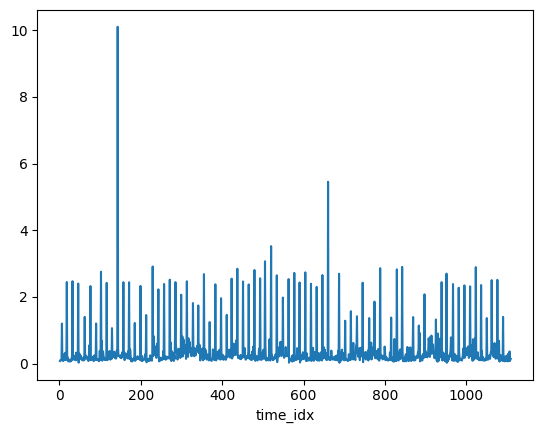

In [57]:
df.set_index('time_idx')['Latency'].plot()

# Create Train & Test Datasets (4 Train / 4 Test)

In [58]:
df.sort_values('Latency')

,DateTime,Latency,unique_id,time_idx
1119673,688200.0558600426,0.0250000000,1,688
1750225,1033500.0314950944,0.0260000000,1,952
1023212,575700.0332579613,0.0280000000,1,564
97004,94500.0376060009,0.0290000000,1,47
1025993,583200.0418879986,0.0330000000,1,591
...,...,...,...,...
635679,285048.2542979717,2.9130000000,1,229
997099,517855.4703168869,3.0690000000,1,505
1001540,525950.7342031002,3.5250000000,1,520
1102972,672652.3528339863,5.4550000000,1,660


### Multistep Datasets

In [60]:
TRAIN_LEN = 600
PRED_LEN = 4

cold_start_time_indices = df[df['Latency'] >= 2.5]['time_idx'].values
cold_start_time_indices = cold_start_time_indices[-10:][::3]

train_dfs = []
test_dfs = []

for idx in cold_start_time_indices:
    train_end_time_idx = idx - PRED_LEN - 1
    train_start_time_idx = train_end_time_idx - TRAIN_LEN
    test_start_time_idx = idx - PRED_LEN
    test_end_time_idx = idx

    # print(train_start_time_idx, train_end_time_idx)
    # print(test_start_time_idx, test_end_time_idx)
    # display(df[df['time_idx'].between(train_start_time_idx, train_end_time_idx)].tail())
    # display(df[df['time_idx'].between(test_start_time_idx, test_end_time_idx)])

    train_dfs.append(df[df['time_idx'].between(train_start_time_idx, train_end_time_idx)])
    test_dfs.append(df[df['time_idx'].between(test_start_time_idx, test_end_time_idx)])

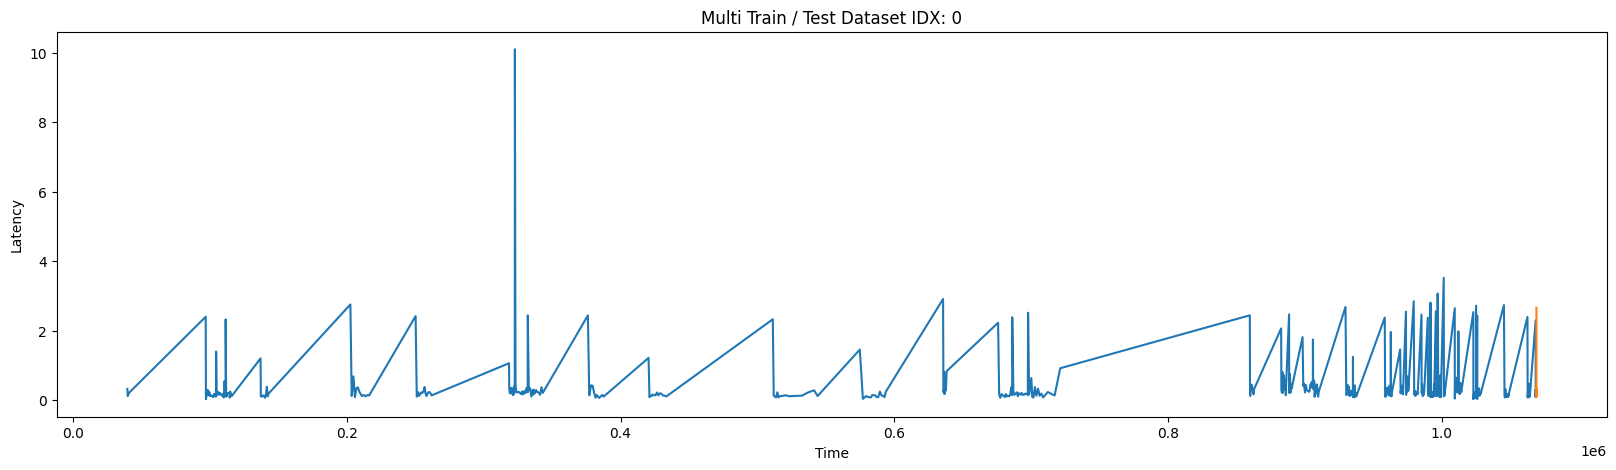

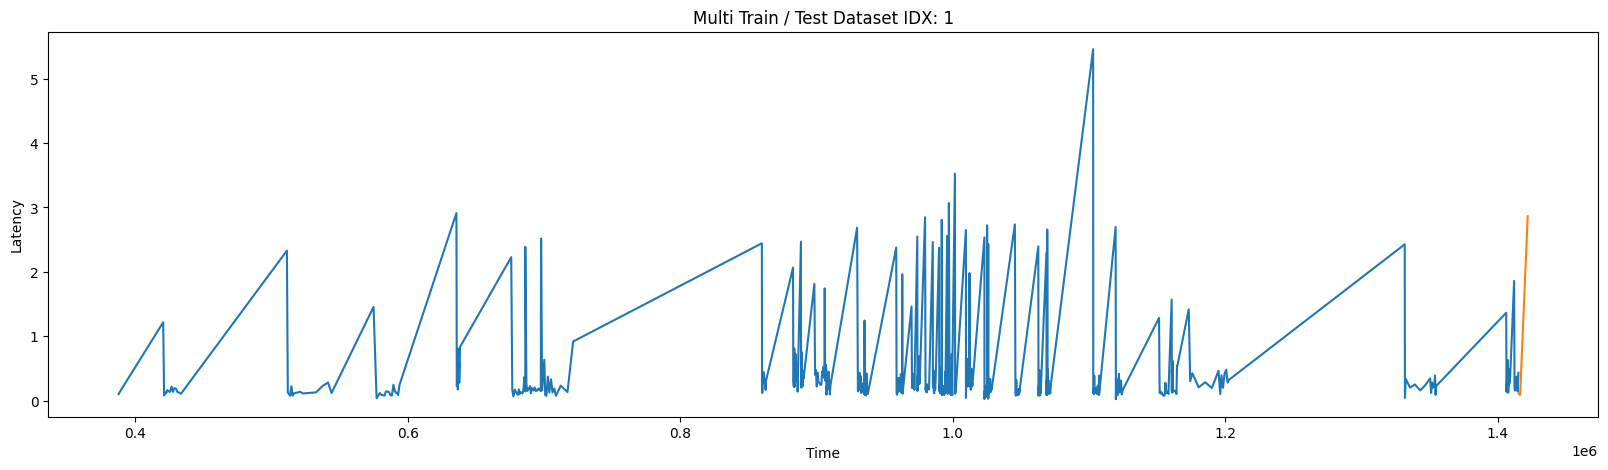

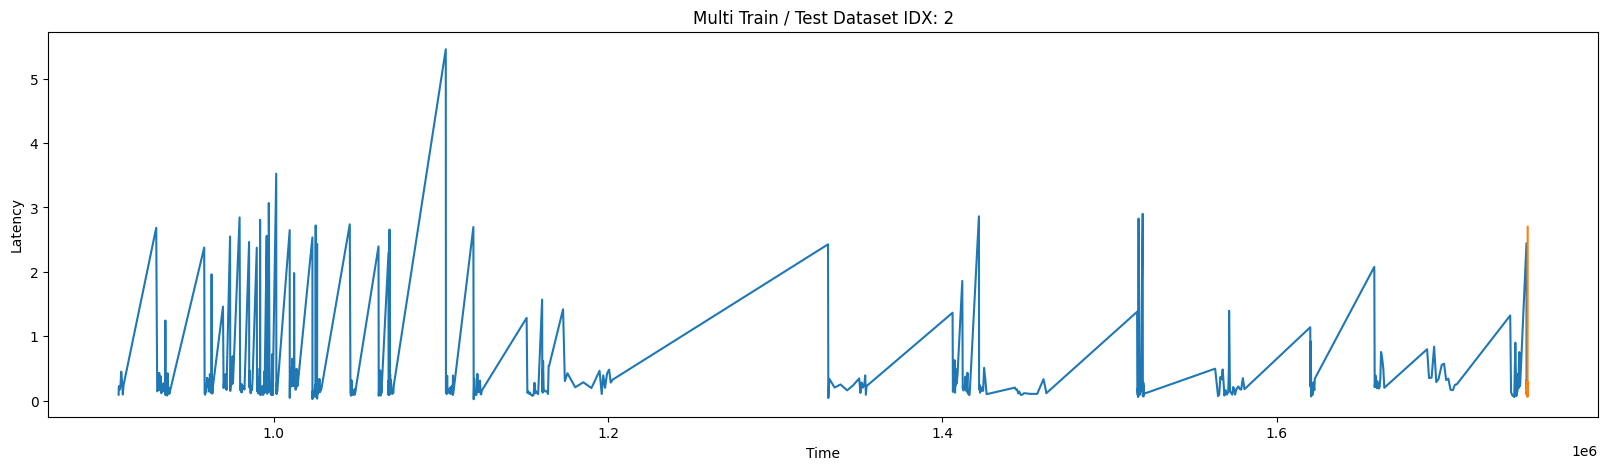

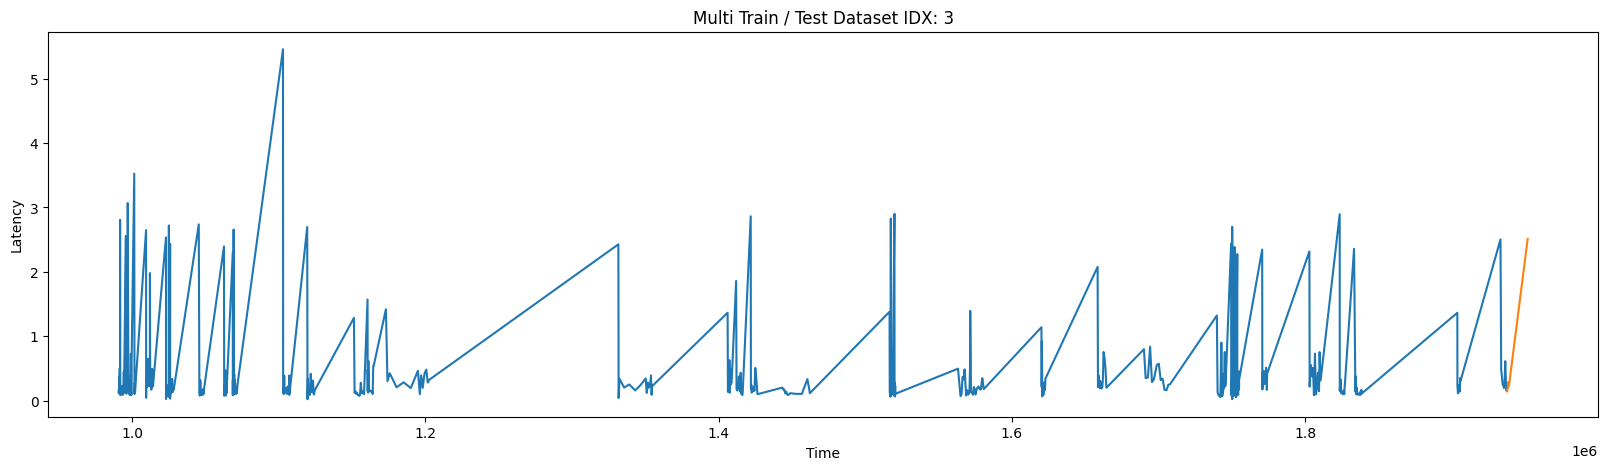

In [61]:
for i in range(len(train_dfs)):
    train_dfs[i]['Latency'].plot(figsize=(20,5), title=f'Multi Train / Test Dataset IDX: {i}')
    test_dfs[i]['Latency'].plot()
    plt.xlabel("Time")
    plt.ylabel("Latency")
    plt.show()

In [62]:
for i in range(len(train_dfs)):
    train_dfs[i].to_excel(f'otherdataset/multistep_train_{i}.xlsx', index=False)
    test_dfs[i].to_excel(f'otherdataset/multistep_test_{i}.xlsx', index=False)

### SingeStep Datasets

In [68]:
cold_start_time_indices

array([ 646,  788,  951, 1076], dtype=int64)

In [63]:
TRAIN_LEN = 600
PRED_LEN = 1

cold_start_time_indices = df[df['Latency'] >= 2.5]['time_idx'].values
cold_start_time_indices = cold_start_time_indices[-10:][::3]

train_dfs = []
test_dfs = []

for idx in cold_start_time_indices:
    train_end_time_idx = idx - PRED_LEN
    train_start_time_idx = train_end_time_idx - TRAIN_LEN
    test_start_time_idx = idx
    test_end_time_idx = idx

    # print(train_start_time_idx, train_end_time_idx)
    # print(test_start_time_idx, test_end_time_idx)
    # display(df[df['time_idx'].between(train_start_time_idx, train_end_time_idx)].tail())
    # display(df[df['time_idx'].between(test_start_time_idx, test_end_time_idx)])

    train_dfs.append(df[df['time_idx'].between(train_start_time_idx, train_end_time_idx)])
    test_dfs.append(df[df['time_idx'].between(test_start_time_idx, test_end_time_idx)])

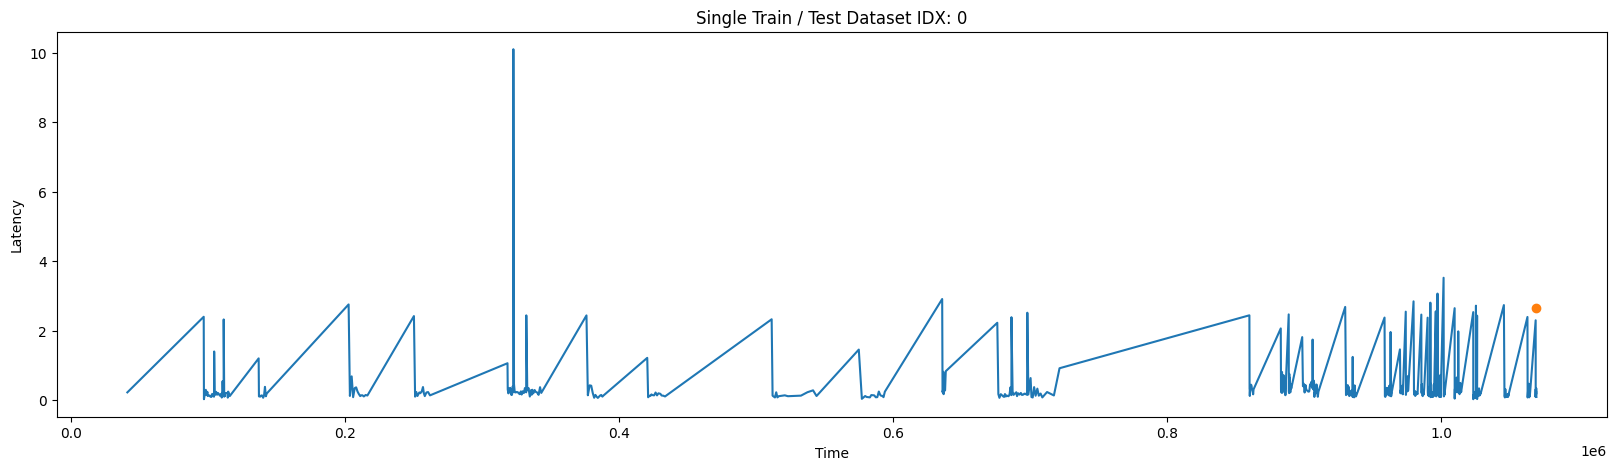

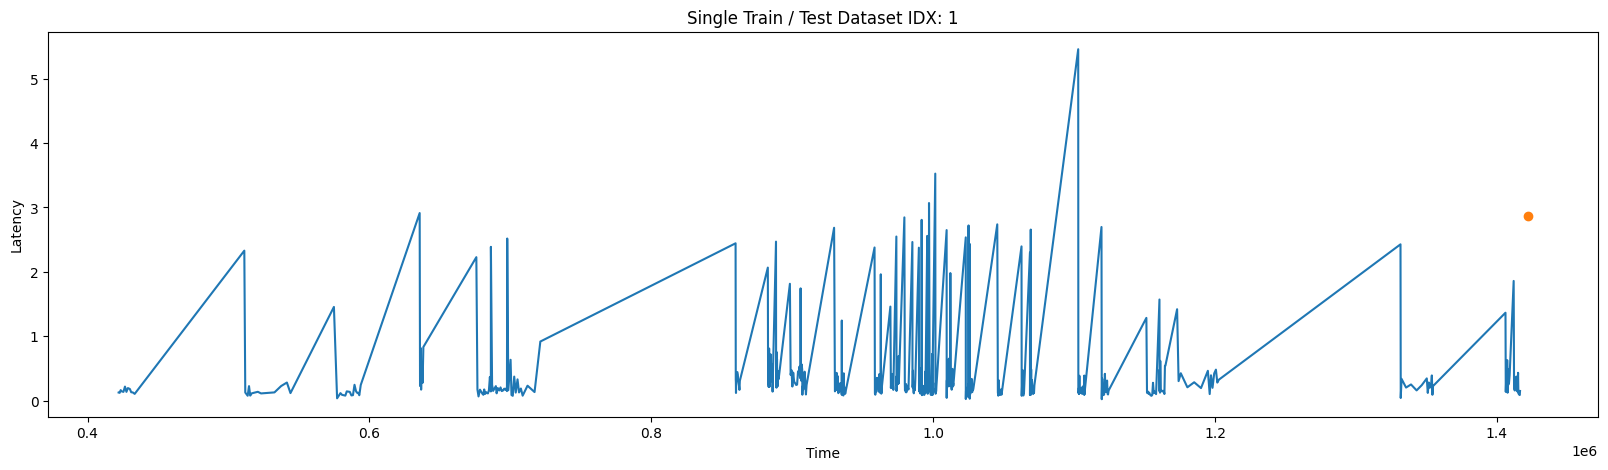

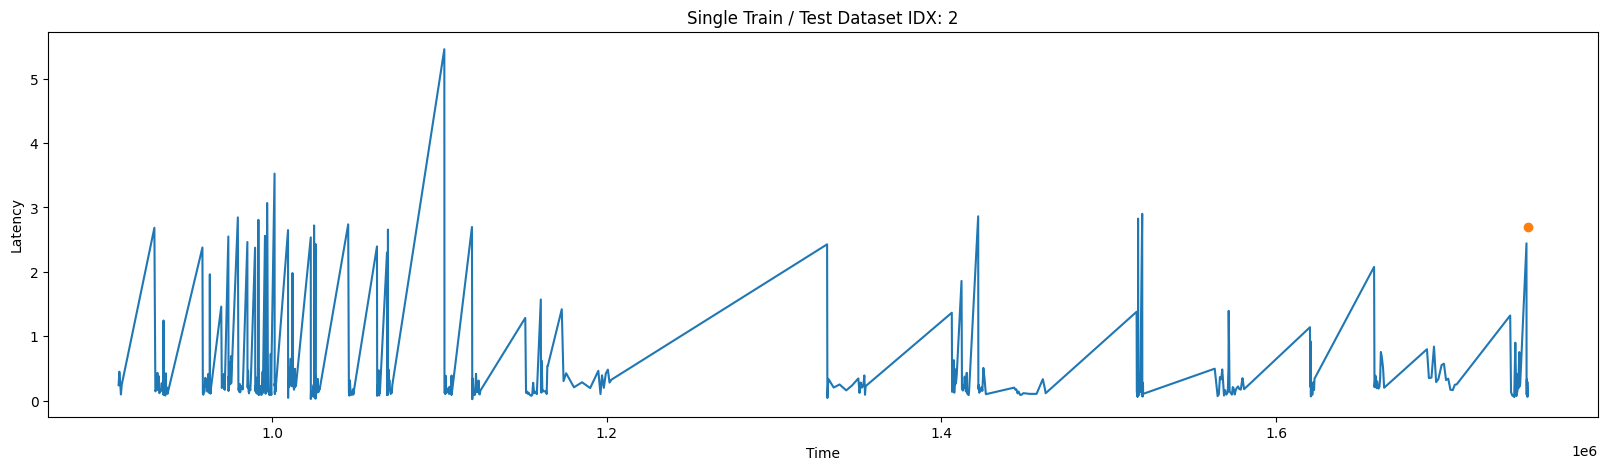

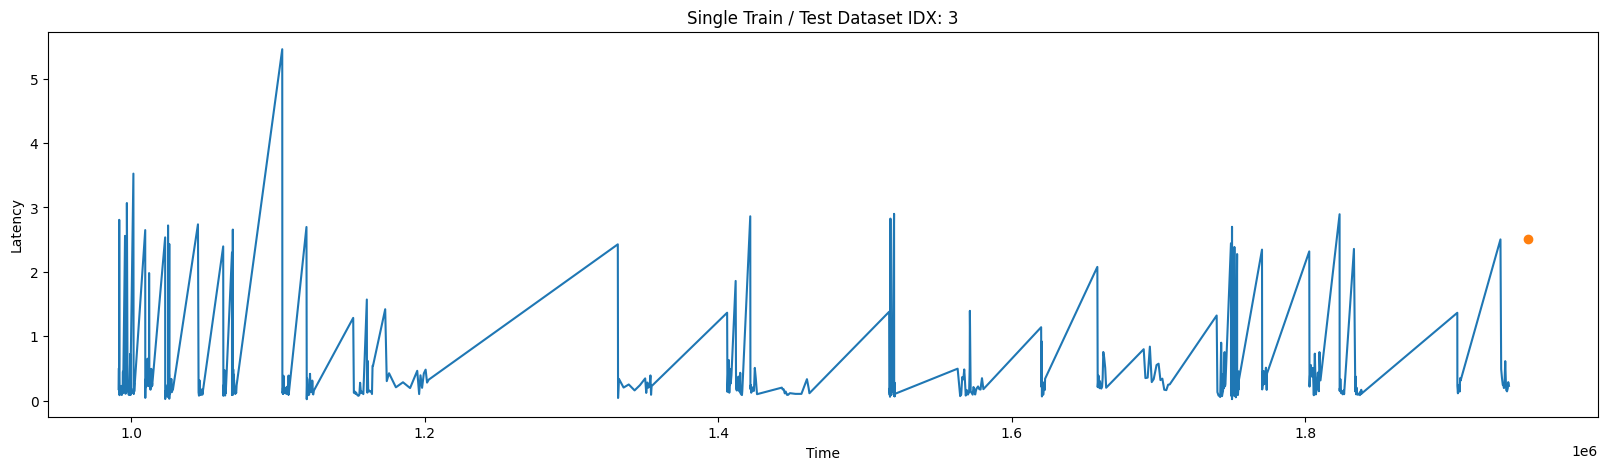

In [64]:
for i in range(len(train_dfs)):
    train_dfs[i]['Latency'].plot(figsize=(20,5), title=f'Single Train / Test Dataset IDX: {i}')
    test_dfs[i]['Latency'].plot(marker='o')
    plt.xlabel("Time")
    plt.ylabel("Latency")
    plt.show()

In [65]:
for i in range(len(train_dfs)):
    train_dfs[i].to_excel(f'otherdataset/singlestep_train_{i}.xlsx', index=False)
    test_dfs[i].to_excel(f'otherdataset/singlestep_test_{i}.xlsx', index=False)

# ML Approach (LGBM, XGB, RND)

In [160]:
all_multistep_results = []
dataset_idx_list = list(range(4))
DATASET_MAIN_DIR = 'otherdataset'
TARGET = 'Latency'
ID_COL = 'unique_id'
TIME_COL = 'time_idx'
SEED = 33
models = [
        LGBMRegressor(random_state=SEED),
        XGBRegressor(random_state=SEED),
        RandomForestRegressor(random_state=SEED),
        #LinearRegression()
    ]
for model in models:
    print(model.__class__.__name__)
    print(model.get_params())
    print('='*50)

LGBMRegressor
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 33, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
XGBRegressor
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'mi

### ML-MultiStep

In [157]:
multistep_last_fold_preds = []
multistep_model_metrics = []
counter = 1
for dataset_id in dataset_idx_list:
    train_path = os.path.join(DATASET_MAIN_DIR, f'multistep_train_{dataset_id}.xlsx')
    test_path = os.path.join(DATASET_MAIN_DIR, f'multistep_test_{dataset_id}.xlsx')

    train = pd.read_excel(train_path)
    test = pd.read_excel(test_path)

    train = train.drop(['DateTime'], axis=1)
    val = test.copy()
    test = test.drop(['DateTime'], axis=1)

    for model in models:
        mlf = MLForecast(
            models = model,
            lags=[1, 2, 3, 4, 5],
            freq = 1,
            # target_transforms=[Differences([1])],
            # lag_transforms={
            # 1: [ExpandingStd()],
            # #3: [RollingMean(window_size=3, min_samples=1)],
            # 6: [RollingMean(window_size=6, min_samples=1)],
            # #9: [RollingMean(window_size=3, min_samples=1)],
            # #12: [RollingMean(window_size=12, min_samples=1)]
            # },
        )
        train[ID_COL] = train[ID_COL].astype(int)
        test[ID_COL] = test[ID_COL].astype(int)
        t1 = time.perf_counter()
        mlf.fit(train, id_col=ID_COL, target_col=TARGET, time_col=TIME_COL)
        t2 = time.perf_counter()
        #print(f'Training Time For {model.__class__.__name__}:', t2-t1)
        preds = mlf.predict(len(test))
        t3 = time.perf_counter()
        # print(f'Prediction Time For {model.__class__.__name__}:', t3-t2)
        preds = preds.merge(test, on=['time_idx', 'unique_id'])
        metrics_dict = {}
        metrics_dict['Fold'] = counter
        metrics_dict['Fold_TrainTime'] = t2-t1
        metrics_dict['Fold_PredictTime'] = t3-t2
        # for estimator in models:
        estimator_name = model.__class__.__name__
        #preds[estimator_name] = preds[estimator_name].astype(int)
        metrics_dict['Model'] = estimator_name
        metrics_dict[f'MAE'] = mean_absolute_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
        metrics_dict[f'MAPE'] = mean_absolute_percentage_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
        metrics_dict[f'RMSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=False)
        metrics_dict[f'MSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=True)
        multistep_model_metrics.append(metrics_dict)

        filt_preds = preds[[estimator_name, TARGET, TIME_COL]].rename(columns={estimator_name: 'Prediction'}).merge(val[['DateTime', 'time_idx']], on='time_idx', how='left')
        filt_preds['Fold'] = counter
        filt_preds['Model'] = estimator_name
        all_multistep_results.append(filt_preds)
        # display(filt_preds)
        if counter == 4:
            multistep_last_fold_df = preds[[estimator_name, TARGET, TIME_COL]].rename(columns={estimator_name: 'Prediction'})
            multistep_last_fold_df['Model'] = estimator_name
            multistep_last_fold_df = multistep_last_fold_df.merge(val[['DateTime', 'time_idx']], on='time_idx', how='left')
            multistep_last_fold_preds.append(multistep_last_fold_df)
    counter += 1

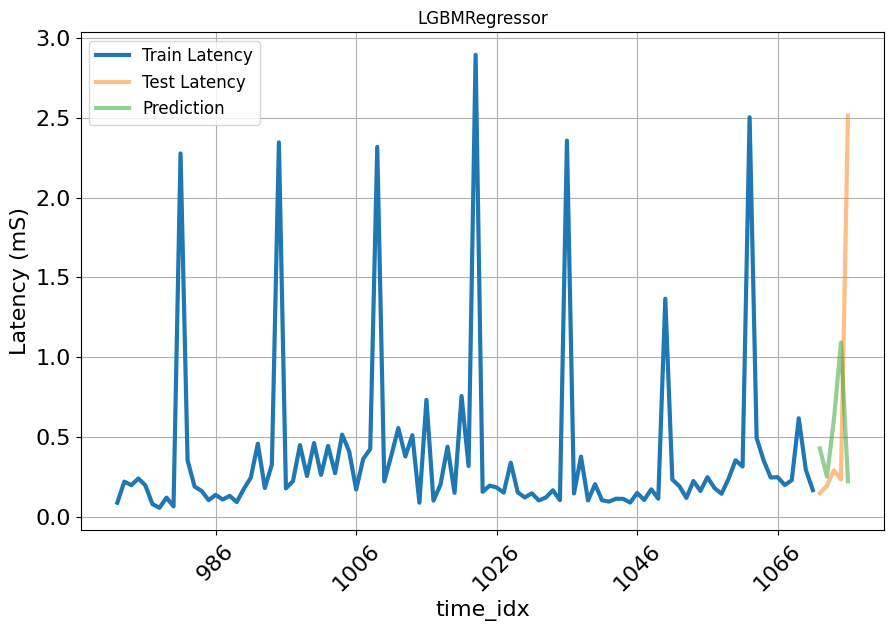

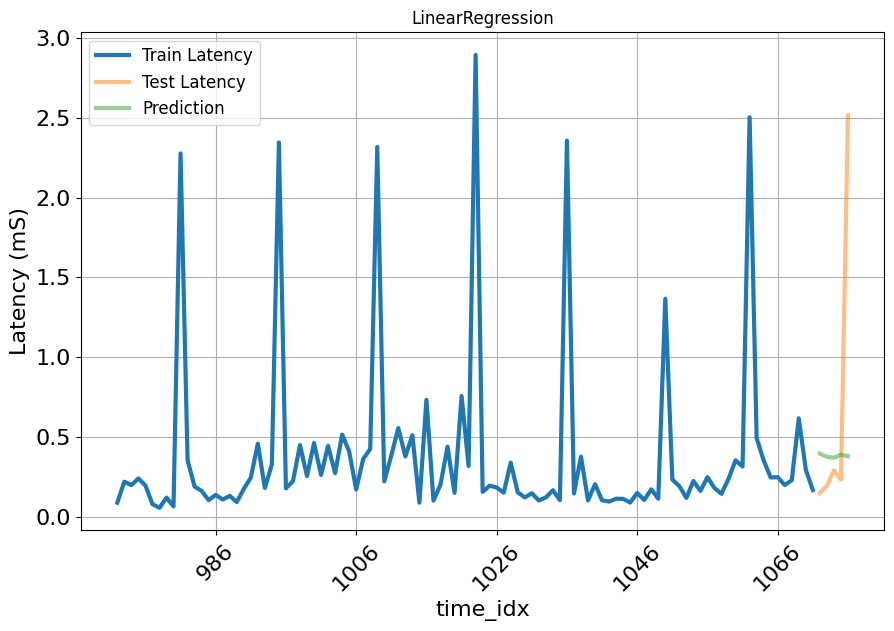

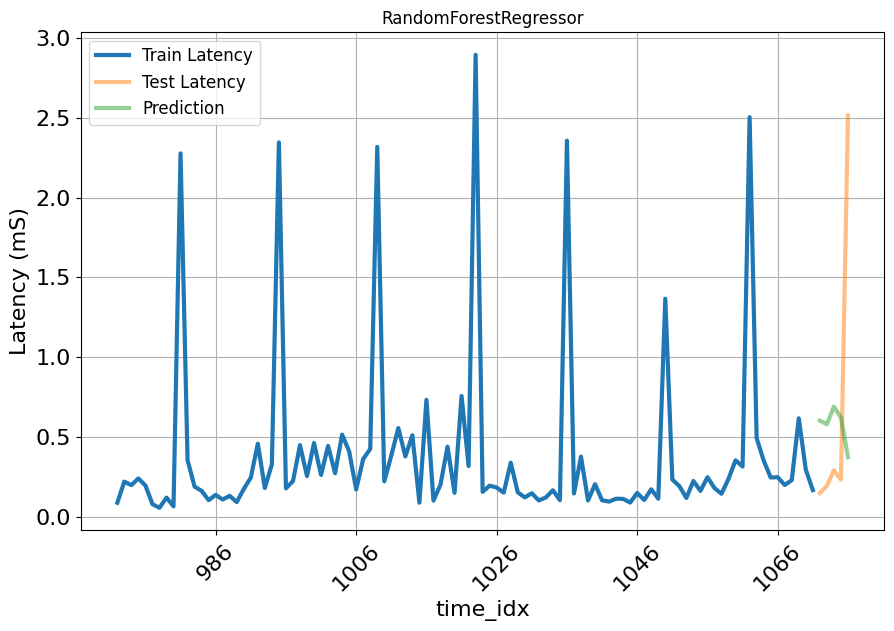

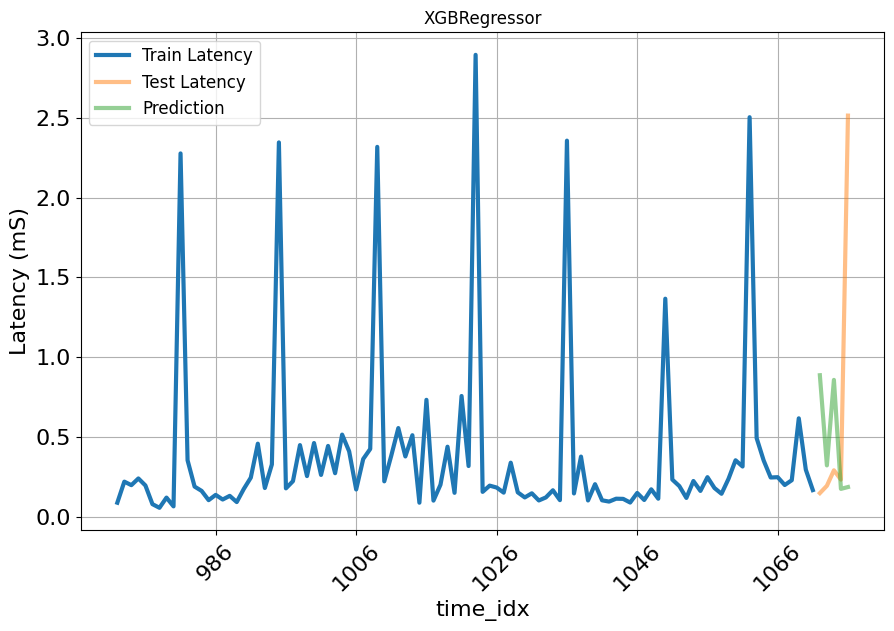

In [158]:
last_fold_train_path = os.path.join(DATASET_MAIN_DIR, f'multistep_train_{dataset_idx_list[-1]}.xlsx')
last_fold_train = pd.read_excel(last_fold_train_path)
multistep_last_fold_preds_df = pd.concat(multistep_last_fold_preds, axis=0)


for idx, grp in multistep_last_fold_preds_df.groupby('Model'):
    last_fold_train[last_fold_train['time_idx'] >= grp['time_idx'].min()-100].set_index('time_idx')['Latency'].plot(figsize=(9,6), label='Train Latency', title=idx, fontsize=16, lw=3)
    grp.set_index('time_idx')['Latency'].plot(label='Test Latency', lw=3, alpha=0.5)
    grp.set_index('time_idx')['Prediction'].plot(label='Prediction', lw=3, alpha=0.5)
    x_axis_values = pd.concat([last_fold_train[last_fold_train['time_idx'] >= cold_start_time_indices[0]-100]['time_idx'], grp['time_idx']], axis=0)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.xticks(x_axis_values.values[::20], rotation=45)
    plt.ylabel('Latency (mS)', fontsize=16)
    plt.xlabel('time_idx', fontsize=16)
    plt.grid()
    plt.autoscale(tight=False)
    plt.savefig(f'plots_azure_dataset/multistep_{idx}_plot.png')
    plt.show()

In [ ]:
# Train Data After Preprocessing (Difference 5)
mlf.preprocess(train, id_col=ID_COL, target_col=TARGET, time_col=TIME_COL, static_features=[ID_COL])['Latency'].plot(figsize=(20,5))

In [159]:
multistep_results = pd.DataFrame(multistep_model_metrics)
display(multistep_results)
display(multistep_results.groupby('Model')[['Fold_TrainTime', 'Fold_PredictTime', 'MAE', 'MAPE', 'RMSE', 'MSE']].mean())

,Fold,Fold_TrainTime,Fold_PredictTime,Model,MAE,MAPE,RMSE,MSE
0,1,0.115,0.040,LGBMRegressor,0.672,2.067,1.046,1.095
1,1,0.177,0.060,XGBRegressor,1.021,4.909,1.331,1.770
2,1,0.508,0.120,RandomForestRegressor,0.692,2.498,1.015,1.030
3,1,0.016,0.028,LinearRegression,0.646,1.742,1.039,1.081
4,2,0.185,0.043,LGBMRegressor,0.777,2.480,1.169,1.368
5,2,0.162,0.047,XGBRegressor,0.599,2.991,0.775,0.601
6,2,0.808,0.166,RandomForestRegressor,0.749,2.336,1.187,1.408
7,2,0.031,0.054,LinearRegression,0.721,2.291,1.141,1.302
8,3,0.248,0.051,LGBMRegressor,0.757,3.760,1.055,1.112
9,3,0.234,0.066,XGBRegressor,0.810,2.701,1.241,1.540


,Fold_TrainTime,Fold_PredictTime,MAE,MAPE,RMSE,MSE
Model,,,,,,
LGBMRegressor,0.162,0.043,0.742,2.472,1.095,1.202
LinearRegression,0.021,0.036,0.647,1.812,1.055,1.116
RandomForestRegressor,0.602,0.121,0.713,2.207,1.073,1.156
XGBRegressor,0.187,0.055,0.799,3.092,1.117,1.293


### ML-SingleStep

In [84]:
singlestep_last_fold_preds = []
singlestep_model_metrics = []
counter = 1
for dataset_id in dataset_idx_list:
    train_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_train_{dataset_id}.xlsx')
    test_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_test_{dataset_id}.xlsx')

    train = pd.read_excel(train_path)
    test = pd.read_excel(test_path)

    train = train.drop(['DateTime'], axis=1)
    test = test.drop(['DateTime'], axis=1)

    for model in models:
        mlf = MLForecast(
            models = model,
            lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
            freq = 1,
            target_transforms=[Differences([5])],
            lag_transforms={
            1: [ExpandingStd()],
            #3: [RollingMean(window_size=3, min_samples=1)],
            6: [RollingMean(window_size=6, min_samples=1)],
            #9: [RollingMean(window_size=3, min_samples=1)],
            #12: [RollingMean(window_size=12, min_samples=1)]
            },
        )
        train[ID_COL] = train[ID_COL].astype(int)
        test[ID_COL] = test[ID_COL].astype(int)
        t1 = time.perf_counter()
        mlf.fit(train, id_col=ID_COL, target_col=TARGET, time_col=TIME_COL, static_features=[ID_COL])
        t2 = time.perf_counter()
        #print(f'Training Time For {model.__class__.__name__}:', t2-t1)
        preds = mlf.predict(len(test))
        t3 = time.perf_counter()
        # print(f'Prediction Time For {model.__class__.__name__}:', t3-t2)
        preds = preds.merge(test, on=['time_idx', 'unique_id'])
        metrics_dict = {}
        metrics_dict['Fold'] = counter
        metrics_dict['Fold_TrainTime'] = t2-t1
        metrics_dict['Fold_PredictTime'] = t3-t2
        # for estimator in models:
        estimator_name = model.__class__.__name__
        preds[estimator_name] = preds[estimator_name].astype(int)
        metrics_dict['Model'] = estimator_name
        metrics_dict[f'MAE'] = mean_absolute_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
        metrics_dict[f'MAPE'] = mean_absolute_percentage_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
        metrics_dict[f'RMSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=False)
        metrics_dict[f'MSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=True)
        singlestep_model_metrics.append(metrics_dict)

        if counter == 4:
            singlestep_last_fold_df = preds[[estimator_name, TARGET, TIME_COL]].rename(columns={estimator_name: 'Prediction'})
            singlestep_last_fold_df['Model'] = estimator_name
            test = pd.read_excel(test_path)
            singlestep_last_fold_df = singlestep_last_fold_df.merge(test[['DateTime', 'time_idx']], on='time_idx', how='left')
            singlestep_last_fold_preds.append(singlestep_last_fold_df)
    counter += 1

In [ ]:
last_fold_train_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_train_{dataset_idx_list[-1]}.xlsx')
last_fold_train = pd.read_excel(last_fold_train_path)
singlestep_last_fold_preds_df = pd.concat(singlestep_last_fold_preds, axis=0)


for idx, grp in singlestep_last_fold_preds_df.groupby('Model'):
    last_fold_train[last_fold_train['time_idx'] >= grp['time_idx'].min()-100].set_index('time_idx')['Latency'].plot(figsize=(9,6), label='Train Latency', title=idx, fontsize=16, lw=3)
    grp.set_index('time_idx')['Latency'].plot(label='Test Latency', lw=3, alpha=0.5, marker='o')
    grp.set_index('time_idx')['Prediction'].plot(label='Prediction', lw=3, alpha=0.5, marker='o')
    x_axis_values = pd.concat([last_fold_train[last_fold_train['time_idx'] >= cold_start_time_indices[0]-100]['time_idx'], grp['time_idx']], axis=0)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.xticks(x_axis_values.values[::20], rotation=45)
    plt.ylabel('Latency (mS)', fontsize=16)
    plt.xlabel('time_idx', fontsize=16)
    plt.grid()
    plt.autoscale(tight=False)
    plt.savefig(f'plots_azure_dataset/singlestep_{idx}_plot.png')
    plt.show()

In [ ]:
# Train Data After Preprocessing (Difference 5)
mlf.preprocess(train, id_col=ID_COL, target_col=TARGET, time_col=TIME_COL, static_features=[ID_COL])['Latency'].plot()

In [88]:
singlestep_results = pd.DataFrame(singlestep_model_metrics)
display(singlestep_results)
display(singlestep_results.groupby('Model')[['Fold_TrainTime', 'Fold_PredictTime', 'MAE', 'MAPE', 'RMSE', 'MSE']].mean())

,Fold,Fold_TrainTime,Fold_PredictTime,Model,MAE,MAPE,RMSE,MSE
0,1,0.1420946000,0.0095977000,LGBMRegressor,0.6570000000,0.2472713587,0.6570000000,0.4316490000
1,1,0.1857137000,0.0114199000,XGBRegressor,0.6570000000,0.2472713587,0.6570000000,0.4316490000
2,1,0.6935846000,0.0435949000,RandomForestRegressor,0.6570000000,0.2472713587,0.6570000000,0.4316490000
3,2,0.0932610000,0.0071320000,LGBMRegressor,1.8630000000,0.6507160321,1.8630000000,3.4707690000
4,2,0.1690044000,0.0097181000,XGBRegressor,1.8630000000,0.6507160321,1.8630000000,3.4707690000
5,2,0.6113270000,0.0108912000,RandomForestRegressor,1.8630000000,0.6507160321,1.8630000000,3.4707690000
6,3,0.0882782000,0.0087376000,LGBMRegressor,2.7000000000,1.0000000000,2.7000000000,7.2900000000
7,3,0.1656407000,0.0103094000,XGBRegressor,2.7000000000,1.0000000000,2.7000000000,7.2900000000
8,3,0.6058956000,0.0110497000,RandomForestRegressor,2.7000000000,1.0000000000,2.7000000000,7.2900000000
9,4,0.0903023000,0.0073648000,LGBMRegressor,1.5140000000,0.6022275259,1.5140000000,2.2921960000


,Fold_TrainTime,Fold_PredictTime,MAE,MAPE,RMSE,MSE
Model,,,,,,
LGBMRegressor,0.1034840250,0.0082080250,1.6835000000,0.6250537292,1.6835000000,3.3711535000
RandomForestRegressor,0.6382388000,0.0195451750,1.6835000000,0.6250537292,1.6835000000,3.3711535000
XGBRegressor,0.1723792250,0.0104677000,1.6835000000,0.6250537292,1.6835000000,3.3711535000


# ARIMA

### MultiStep

In [165]:
print(AutoARIMA(seasonal=False).__weakref__)

None


In [166]:
multistep_last_fold_preds = []
multistep_model_metrics = []
counter = 1
for dataset_id in dataset_idx_list:
    train_path = os.path.join(DATASET_MAIN_DIR, f'multistep_train_{dataset_id}.xlsx')
    test_path = os.path.join(DATASET_MAIN_DIR, f'multistep_test_{dataset_id}.xlsx')

    train = pd.read_excel(train_path)
    test = pd.read_excel(test_path)

    train = train.drop(['DateTime'], axis=1)
    val = test.copy()
    test = test.drop(['DateTime'], axis=1)

    train['first_col'] = 1
    test['first_col'] = 1

    # train = train[[ID_COL, TIME_COL, TARGET, 'Request', 'CPU_Usage', 'Memory_Usage']]
    # test = test[[ID_COL, TIME_COL, TARGET, 'Request', 'CPU_Usage', 'Memory_Usage']]

    sf = StatsForecast(
        models = [AutoARIMA(seasonal=False)],
        freq = 1
        )
    
    train[ID_COL] = train[ID_COL].astype(int)
    test[ID_COL] = test[ID_COL].astype(int)

    t1 = time.perf_counter()
    sf.fit(train, id_col=ID_COL, target_col=TARGET, time_col=TIME_COL)
    t2 = time.perf_counter()
    #print(f'Training Time For {model.__class__.__name__}:', t2-t1)
    preds = sf.predict(h=len(test), X_df=test.drop(TARGET, axis=1))
    t3 = time.perf_counter()
    # print(f'Prediction Time For {model.__class__.__name__}:', t3-t2)
    preds = preds.merge(test, on=['time_idx', 'unique_id'])
    metrics_dict = {}
    metrics_dict['Fold'] = counter
    metrics_dict['Fold_TrainTime'] = t2-t1
    metrics_dict['Fold_PredictTime'] = t3-t2
    # for estimator in models:
    estimator_name = AutoARIMA(seasonal=False).__class__.__name__
    preds[estimator_name] = preds[estimator_name].astype(int)
    metrics_dict['Model'] = estimator_name
    metrics_dict[f'MAE'] = mean_absolute_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
    metrics_dict[f'MAPE'] = mean_absolute_percentage_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
    metrics_dict[f'RMSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=False)
    metrics_dict[f'MSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=True)
    multistep_model_metrics.append(metrics_dict)

    filt_preds = preds[[estimator_name, TARGET, TIME_COL]].rename(columns={estimator_name: 'Prediction'}).merge(val[['DateTime', 'time_idx']], on='time_idx', how='left')
    filt_preds['Fold'] = counter
    filt_preds['Model'] = 'ARIMA'
    all_multistep_results.append(filt_preds)

    if counter == 4:
        multistep_last_fold_df = preds[[estimator_name, TARGET, TIME_COL]].rename(columns={estimator_name: 'Prediction'})
        multistep_last_fold_df['Model'] = estimator_name
        test = pd.read_excel(test_path)
        multistep_last_fold_df = multistep_last_fold_df.merge(test[['DateTime', 'time_idx']], on='time_idx', how='left')
        multistep_last_fold_preds.append(multistep_last_fold_df)
    counter += 1
    break

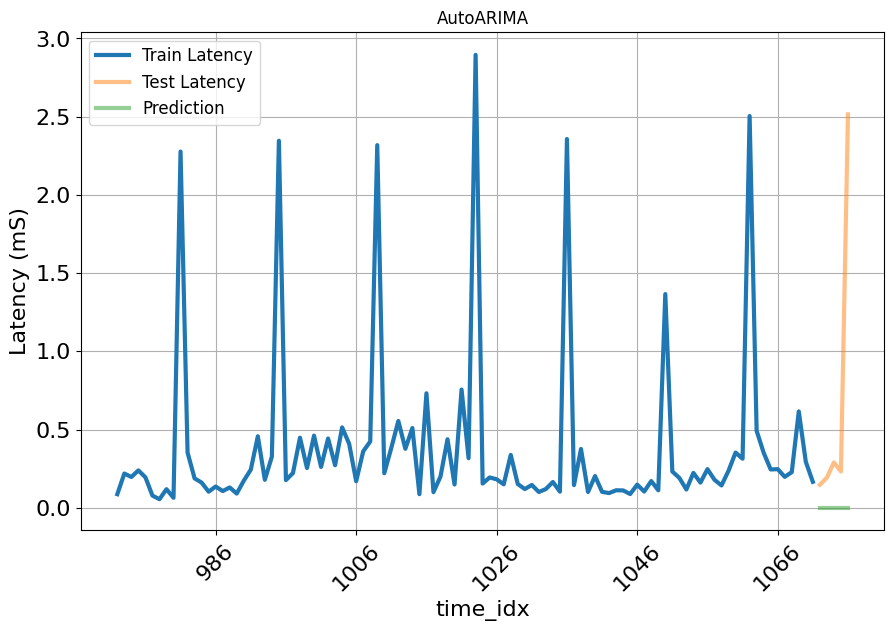

In [93]:
last_fold_train_path = os.path.join(DATASET_MAIN_DIR, f'multistep_train_{dataset_idx_list[-1]}.xlsx')
last_fold_train = pd.read_excel(last_fold_train_path)
multistep_last_fold_preds_df = pd.concat(multistep_last_fold_preds, axis=0)


for idx, grp in multistep_last_fold_preds_df.groupby('Model'):
    last_fold_train[last_fold_train['time_idx'] >= grp['time_idx'].min()-100].set_index('time_idx')['Latency'].plot(figsize=(9,6), label='Train Latency', title=idx, fontsize=16, lw=3)
    grp.set_index('time_idx')['Latency'].plot(label='Test Latency', lw=3, alpha=0.5)
    grp.set_index('time_idx')['Prediction'].plot(label='Prediction', lw=3, alpha=0.5)
    x_axis_values = pd.concat([last_fold_train[last_fold_train['time_idx'] >= cold_start_time_indices[0]-100]['time_idx'], grp['time_idx']], axis=0)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.xticks(x_axis_values.values[::20], rotation=45)
    plt.ylabel('Latency (mS)', fontsize=16)
    plt.xlabel('time_idx', fontsize=16)
    plt.grid()
    plt.autoscale(tight=False)
    plt.savefig(f'plots_azure_dataset/multistep_ARIMA_{idx}_plot.png')
    plt.show()

In [94]:
multistep_results = pd.DataFrame(multistep_model_metrics)
display(multistep_results)
display(multistep_results.groupby('Model')[['Fold_TrainTime', 'Fold_PredictTime', 'MAE', 'MAPE', 'RMSE', 'MSE']].mean())

,Fold,Fold_TrainTime,Fold_PredictTime,Model,MAE,MAPE,RMSE,MSE
0,1,0.6353554000,1.7447343000,AutoARIMA,0.6756000000,1.0000000000,1.2024621408,1.4459152000
1,2,0.5138616000,0.0051714000,AutoARIMA,0.6630000000,1.0000000000,1.2845530740,1.6500766000
2,3,0.4589337000,0.0049913000,AutoARIMA,0.6666000000,1.0000000000,1.2185884457,1.4849578000
3,4,0.5774222000,0.0058346000,AutoARIMA,0.6752000000,1.0000000000,1.1416635231,1.3033956000


,Fold_TrainTime,Fold_PredictTime,MAE,MAPE,RMSE,MSE
Model,,,,,,
AutoARIMA,0.5463932250,0.4401829000,0.6701000000,1.0000000000,1.2118167959,1.4710863000


### SingleStep

In [95]:
singlestep_last_fold_preds = []
singlestep_model_metrics = []
counter = 1
for dataset_id in dataset_idx_list:
    train_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_train_{dataset_id}.xlsx')
    test_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_test_{dataset_id}.xlsx')

    train = pd.read_excel(train_path)
    test = pd.read_excel(test_path)

    train = train.drop(['DateTime'], axis=1)
    test = test.drop(['DateTime'], axis=1)

    # train = train[[ID_COL, TIME_COL, TARGET, 'Request', 'CPU_Usage', 'Memory_Usage']]
    # test = test[[ID_COL, TIME_COL, TARGET, 'Request', 'CPU_Usage', 'Memory_Usage']]

    train['first_col'] = 1
    test['first_col'] = 1

    sf = StatsForecast(
        models = [AutoARIMA(seasonal=False)],
        freq = 1
        )
    
    train[ID_COL] = train[ID_COL].astype(int)
    test[ID_COL] = test[ID_COL].astype(int)

    t1 = time.perf_counter()
    sf.fit(train, id_col=ID_COL, target_col=TARGET, time_col=TIME_COL)
    t2 = time.perf_counter()
    #print(f'Training Time For {model.__class__.__name__}:', t2-t1)
    preds = sf.predict(h=len(test), X_df=test.drop(TARGET, axis=1))
    t3 = time.perf_counter()
    # print(f'Prediction Time For {model.__class__.__name__}:', t3-t2)
    preds = preds.merge(test, on=['time_idx', 'unique_id'])
    metrics_dict = {}
    metrics_dict['Fold'] = counter
    metrics_dict['Fold_TrainTime'] = t2-t1
    metrics_dict['Fold_PredictTime'] = t3-t2
    # for estimator in models:
    estimator_name = AutoARIMA(seasonal=False).__class__.__name__
    preds[estimator_name] = preds[estimator_name].astype(int)
    metrics_dict['Model'] = estimator_name
    metrics_dict[f'MAE'] = mean_absolute_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
    metrics_dict[f'MAPE'] = mean_absolute_percentage_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
    metrics_dict[f'RMSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=False)
    metrics_dict[f'MSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=True)
    singlestep_model_metrics.append(metrics_dict)

    if counter == 4:
        singlestep_last_fold_df = preds[[estimator_name, TARGET, TIME_COL]].rename(columns={estimator_name: 'Prediction'})
        singlestep_last_fold_df['Model'] = estimator_name
        test = pd.read_excel(test_path)
        singlestep_last_fold_df = singlestep_last_fold_df.merge(test[['DateTime', 'time_idx']], on='time_idx', how='left')
        singlestep_last_fold_preds.append(singlestep_last_fold_df)
    counter += 1

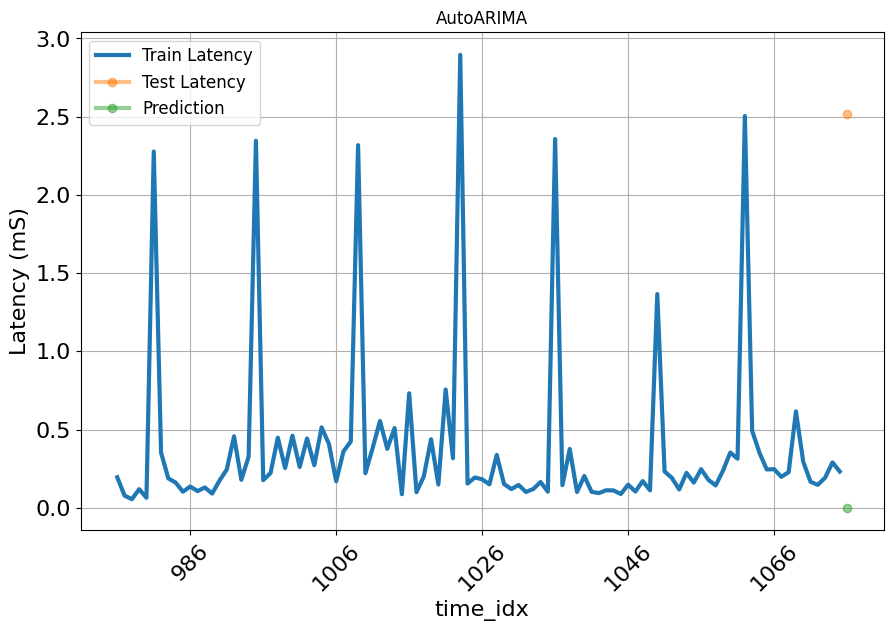

In [96]:
last_fold_train_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_train_{dataset_idx_list[-1]}.xlsx')
last_fold_train = pd.read_excel(last_fold_train_path)
singlestep_last_fold_preds_df = pd.concat(singlestep_last_fold_preds, axis=0)


for idx, grp in singlestep_last_fold_preds_df.groupby('Model'):
    last_fold_train[last_fold_train['time_idx'] >= grp['time_idx'].min()-100].set_index('time_idx')['Latency'].plot(figsize=(9,6), label='Train Latency', title=idx, fontsize=16, lw=3)
    grp.set_index('time_idx')['Latency'].plot(label='Test Latency', lw=3, alpha=0.5, marker='o')
    grp.set_index('time_idx')['Prediction'].plot(label='Prediction', lw=3, alpha=0.5, marker='o')
    x_axis_values = pd.concat([last_fold_train[last_fold_train['time_idx'] >= cold_start_time_indices[0]-100]['time_idx'], grp['time_idx']], axis=0)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.xticks(x_axis_values.values[::20], rotation=45)
    plt.ylabel('Latency (mS)', fontsize=16)
    plt.xlabel('time_idx', fontsize=16)
    plt.grid()
    plt.autoscale(tight=False)
    plt.savefig(f'plots_azure_dataset/singlestep_ARIMA_{idx}_plot.png')
    plt.show()

In [97]:
singlestep_results = pd.DataFrame(singlestep_model_metrics)
display(singlestep_results)
display(singlestep_results.groupby('Model')[['Fold_TrainTime', 'Fold_PredictTime', 'MAE', 'MAPE', 'RMSE', 'MSE']].mean())

,Fold,Fold_TrainTime,Fold_PredictTime,Model,MAE,MAPE,RMSE,MSE
0,1,0.4187143000,0.0053471000,AutoARIMA,2.6570000000,1.0000000000,2.6570000000,7.0596490000
1,2,0.6465874000,0.0047920001,AutoARIMA,2.8630000000,1.0000000000,2.8630000000,8.1967690000
2,3,0.5267784000,0.0049003000,AutoARIMA,2.7000000000,1.0000000000,2.7000000000,7.2900000000
3,4,0.5045347000,0.0049036000,AutoARIMA,2.5140000000,1.0000000000,2.5140000000,6.3201960000


,Fold_TrainTime,Fold_PredictTime,MAE,MAPE,RMSE,MSE
Model,,,,,,
AutoARIMA,0.5241537000,0.0049857500,2.6835000000,1.0000000000,2.6835000000,7.2166535000


# SARIMA

### MultiStep

In [174]:
multistep_last_fold_preds = []
multistep_model_metrics = []
counter = 1
for dataset_id in dataset_idx_list:
    train_path = os.path.join(DATASET_MAIN_DIR, f'multistep_train_{dataset_id}.xlsx')
    test_path = os.path.join(DATASET_MAIN_DIR, f'multistep_test_{dataset_id}.xlsx')

    train = pd.read_excel(train_path)
    test = pd.read_excel(test_path)

    train = train.drop(['DateTime'], axis=1)
    val = test.copy()
    test = test.drop(['DateTime'], axis=1)

    # train = train[[ID_COL, TIME_COL, TARGET, 'Request', 'CPU_Usage', 'Memory_Usage']]
    # test = test[[ID_COL, TIME_COL, TARGET, 'Request', 'CPU_Usage', 'Memory_Usage']]

    train['first_col'] = 1
    test['first_col'] = 1

    sf = StatsForecast(
        models = [AutoARIMA(seasonal=True, start_P=1, start_Q=0, d=1)],
        freq = 1
        )
    
    train[ID_COL] = train[ID_COL].astype(int)
    test[ID_COL] = test[ID_COL].astype(int)

    t1 = time.perf_counter()
    sf.fit(train, id_col=ID_COL, target_col=TARGET, time_col=TIME_COL)
    t2 = time.perf_counter()
    #print(f'Training Time For {model.__class__.__name__}:', t2-t1)
    preds = sf.predict(h=len(test), X_df=test.drop(TARGET, axis=1))
    t3 = time.perf_counter()
    # print(f'Prediction Time For {model.__class__.__name__}:', t3-t2)
    preds = preds.merge(test, on=['time_idx', 'unique_id'])
    metrics_dict = {}
    metrics_dict['Fold'] = counter
    metrics_dict['Fold_TrainTime'] = t2-t1
    metrics_dict['Fold_PredictTime'] = t3-t2
    # for estimator in models:
    estimator_name = AutoARIMA(seasonal=True).__class__.__name__
    preds[estimator_name] = preds[estimator_name].astype(int)
    metrics_dict['Model'] = estimator_name
    metrics_dict[f'MAE'] = mean_absolute_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
    metrics_dict[f'MAPE'] = mean_absolute_percentage_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
    metrics_dict[f'RMSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=False)
    metrics_dict[f'MSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=True)
    multistep_model_metrics.append(metrics_dict)

    filt_preds = preds[[estimator_name, TARGET, TIME_COL]].rename(columns={estimator_name: 'Prediction'}).merge(val[['DateTime', 'time_idx']], on='time_idx', how='left')
    filt_preds['Fold'] = counter
    filt_preds['Model'] = 'SARIMA'
    all_multistep_results.append(filt_preds)

    if counter == 4:
        multistep_last_fold_df = preds[[estimator_name, TARGET, TIME_COL]].rename(columns={estimator_name: 'Prediction'})
        multistep_last_fold_df['Model'] = estimator_name
        test = pd.read_excel(test_path)
        multistep_last_fold_df = multistep_last_fold_df.merge(test[['DateTime', 'time_idx']], on='time_idx', how='left')
        multistep_last_fold_preds.append(multistep_last_fold_df)
    counter += 1
    break

In [175]:
sf.fitted_[0][0].model_['arma']

(0, 1, 0, 0, 1, 1, 0)

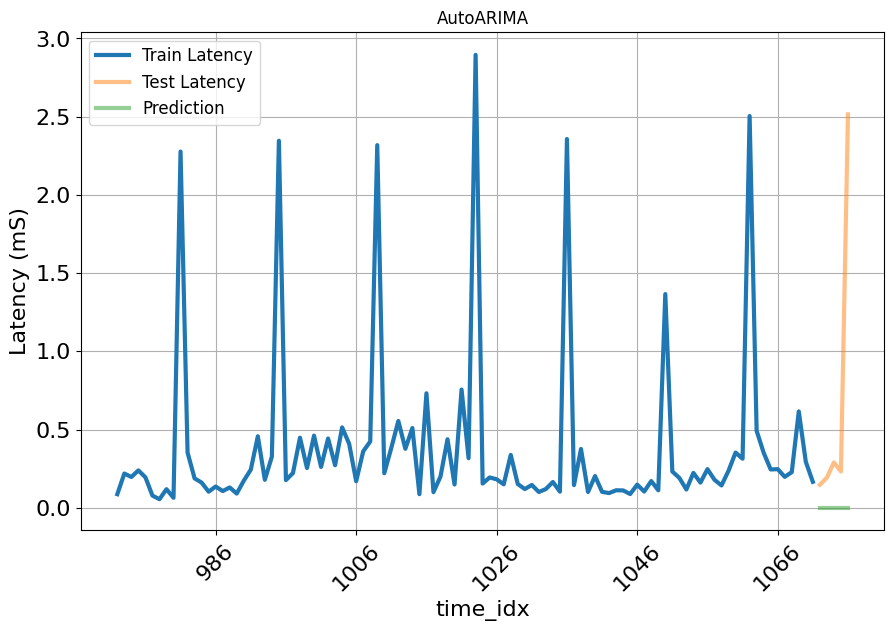

In [99]:
last_fold_train_path = os.path.join(DATASET_MAIN_DIR, f'multistep_train_{dataset_idx_list[-1]}.xlsx')
last_fold_train = pd.read_excel(last_fold_train_path)
multistep_last_fold_preds_df = pd.concat(multistep_last_fold_preds, axis=0)


for idx, grp in multistep_last_fold_preds_df.groupby('Model'):
    last_fold_train[last_fold_train['time_idx'] >= grp['time_idx'].min()-100].set_index('time_idx')['Latency'].plot(figsize=(9,6), label='Train Latency', title=idx, fontsize=16, lw=3)
    grp.set_index('time_idx')['Latency'].plot(label='Test Latency', lw=3, alpha=0.5)
    grp.set_index('time_idx')['Prediction'].plot(label='Prediction', lw=3, alpha=0.5)
    x_axis_values = pd.concat([last_fold_train[last_fold_train['time_idx'] >= cold_start_time_indices[0]-100]['time_idx'], grp['time_idx']], axis=0)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.xticks(x_axis_values.values[::20], rotation=45)
    plt.ylabel('Latency (mS)', fontsize=16)
    plt.xlabel('time_idx', fontsize=16)
    plt.grid()
    plt.autoscale(tight=False)
    plt.savefig(f'plots_azure_dataset/multistep_SARIMA_{idx}_plot.png')
    plt.show()

In [100]:
multistep_results = pd.DataFrame(multistep_model_metrics)
display(multistep_results)
display(multistep_results.groupby('Model')[['Fold_TrainTime', 'Fold_PredictTime', 'MAE', 'MAPE', 'RMSE', 'MSE']].mean())

,Fold,Fold_TrainTime,Fold_PredictTime,Model,MAE,MAPE,RMSE,MSE
0,1,1.9567046000,0.0062307000,AutoARIMA,0.6756000000,1.0000000000,1.2024621408,1.4459152000
1,2,0.7279602000,0.0049066001,AutoARIMA,0.6630000000,1.0000000000,1.2845530740,1.6500766000
2,3,0.5039050000,0.0065969000,AutoARIMA,0.6666000000,1.0000000000,1.2185884457,1.4849578000
3,4,0.6985889000,0.0064402000,AutoARIMA,0.6752000000,1.0000000000,1.1416635231,1.3033956000


,Fold_TrainTime,Fold_PredictTime,MAE,MAPE,RMSE,MSE
Model,,,,,,
AutoARIMA,0.9717896750,0.0060436000,0.6701000000,1.0000000000,1.2118167959,1.4710863000


### SingleStep

In [101]:
singlestep_last_fold_preds = []
singlestep_model_metrics = []
counter = 1
for dataset_id in dataset_idx_list:
    train_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_train_{dataset_id}.xlsx')
    test_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_test_{dataset_id}.xlsx')

    train = pd.read_excel(train_path)
    test = pd.read_excel(test_path)

    train = train.drop(['DateTime'], axis=1)
    test = test.drop(['DateTime'], axis=1)

    # train = train[[ID_COL, TIME_COL, TARGET, 'Request', 'CPU_Usage', 'Memory_Usage']]
    # test = test[[ID_COL, TIME_COL, TARGET, 'Request', 'CPU_Usage', 'Memory_Usage']]

    train['first_col'] = 1
    test['first_col'] = 1

    sf = StatsForecast(
        models = [AutoARIMA(seasonal=True, start_P=1, start_Q=0, d=1)],
        freq = 1
        )
    
    train[ID_COL] = train[ID_COL].astype(int)
    test[ID_COL] = test[ID_COL].astype(int)

    t1 = time.perf_counter()
    sf.fit(train, id_col=ID_COL, target_col=TARGET, time_col=TIME_COL)
    t2 = time.perf_counter()
    #print(f'Training Time For {model.__class__.__name__}:', t2-t1)
    preds = sf.predict(h=len(test), X_df=test.drop(TARGET, axis=1))
    t3 = time.perf_counter()
    # print(f'Prediction Time For {model.__class__.__name__}:', t3-t2)
    preds = preds.merge(test, on=['time_idx', 'unique_id'])
    metrics_dict = {}
    metrics_dict['Fold'] = counter
    metrics_dict['Fold_TrainTime'] = t2-t1
    metrics_dict['Fold_PredictTime'] = t3-t2
    # for estimator in models:
    estimator_name = AutoARIMA(seasonal=False).__class__.__name__
    preds[estimator_name] = preds[estimator_name].astype(int)
    metrics_dict['Model'] = estimator_name
    metrics_dict[f'MAE'] = mean_absolute_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
    metrics_dict[f'MAPE'] = mean_absolute_percentage_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
    metrics_dict[f'RMSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=False)
    metrics_dict[f'MSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=True)
    singlestep_model_metrics.append(metrics_dict)

    if counter == 4:
        singlestep_last_fold_df = preds[[estimator_name, TARGET, TIME_COL]].rename(columns={estimator_name: 'Prediction'})
        singlestep_last_fold_df['Model'] = estimator_name
        test = pd.read_excel(test_path)
        singlestep_last_fold_df = singlestep_last_fold_df.merge(test[['DateTime', 'time_idx']], on='time_idx', how='left')
        singlestep_last_fold_preds.append(singlestep_last_fold_df)
    counter += 1

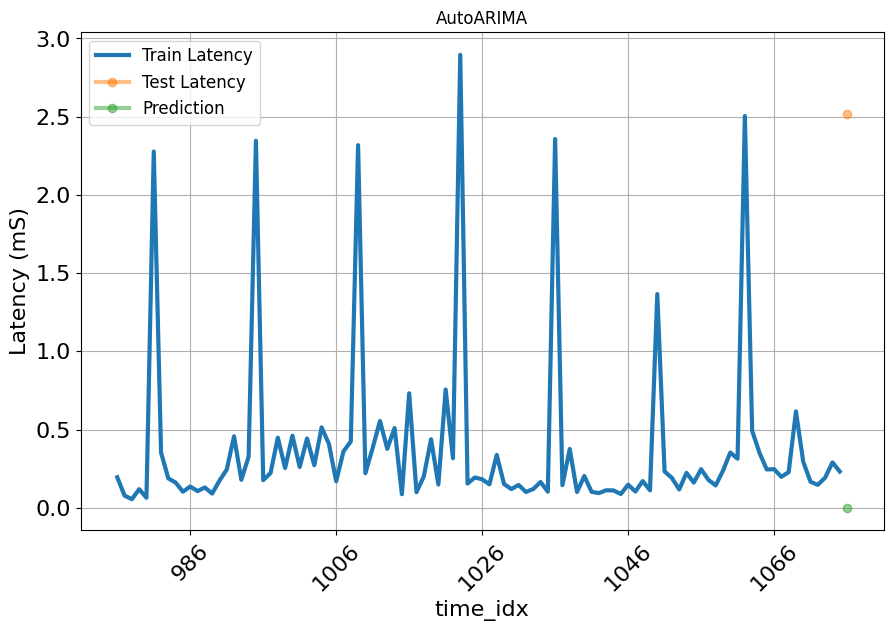

In [102]:
last_fold_train_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_train_{dataset_idx_list[-1]}.xlsx')
last_fold_train = pd.read_excel(last_fold_train_path)
singlestep_last_fold_preds_df = pd.concat(singlestep_last_fold_preds, axis=0)


for idx, grp in singlestep_last_fold_preds_df.groupby('Model'):
    last_fold_train[last_fold_train['time_idx'] >= grp['time_idx'].min()-100].set_index('time_idx')['Latency'].plot(figsize=(9,6), label='Train Latency', title=idx, fontsize=16, lw=3)
    grp.set_index('time_idx')['Latency'].plot(label='Test Latency', lw=3, alpha=0.5, marker='o')
    grp.set_index('time_idx')['Prediction'].plot(label='Prediction', lw=3, alpha=0.5, marker='o')
    x_axis_values = pd.concat([last_fold_train[last_fold_train['time_idx'] >= cold_start_time_indices[0]-100]['time_idx'], grp['time_idx']], axis=0)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.xticks(x_axis_values.values[::20], rotation=45)
    plt.ylabel('Latency (mS)', fontsize=16)
    plt.xlabel('time_idx', fontsize=16)
    plt.grid()
    plt.autoscale(tight=False)
    plt.savefig(f'plots_azure_dataset/singlestep_SARIMA_{idx}_plot.png')
    plt.show()

In [103]:
singlestep_results = pd.DataFrame(singlestep_model_metrics)
display(singlestep_results)
display(singlestep_results.groupby('Model')[['Fold_TrainTime', 'Fold_PredictTime', 'MAE', 'MAPE', 'RMSE', 'MSE']].mean())

,Fold,Fold_TrainTime,Fold_PredictTime,Model,MAE,MAPE,RMSE,MSE
0,1,0.7447724000,0.0099029000,AutoARIMA,2.6570000000,1.0000000000,2.6570000000,7.0596490000
1,2,0.7387741000,0.0058484000,AutoARIMA,2.8630000000,1.0000000000,2.8630000000,8.1967690000
2,3,0.9411505000,0.0115643000,AutoARIMA,2.7000000000,1.0000000000,2.7000000000,7.2900000000
3,4,0.7422200000,0.0054805000,AutoARIMA,2.5140000000,1.0000000000,2.5140000000,6.3201960000


,Fold_TrainTime,Fold_PredictTime,MAE,MAPE,RMSE,MSE
Model,,,,,,
AutoARIMA,0.7917292500,0.0081990250,2.6835000000,1.0000000000,2.6835000000,7.2166535000


# LSTM

### MultiStep

In [ ]:
multistep_last_fold_preds = []
multistep_model_metrics = []
counter = 1
for dataset_id in dataset_idx_list:
    train_path = os.path.join(DATASET_MAIN_DIR, f'multistep_train_{dataset_id}.xlsx')
    test_path = os.path.join(DATASET_MAIN_DIR, f'multistep_test_{dataset_id}.xlsx')

    train = pd.read_excel(train_path)
    test = pd.read_excel(test_path)

    train = train.drop(['DateTime'], axis=1)
    val = test.copy()
    test = test.drop(['DateTime'], axis=1)

    # future_exog_features = [c for c in train.columns if c not in [ID_COL, TIME_COL, TARGET, 'CPU_Usage', 'Memory_Usage']]
    # historical_exog_features = ['CPU_Usage', 'Memory_Usage']
    train = train.rename(columns={ID_COL: 'unique_id', TIME_COL: 'ds', TARGET: 'y'})
    test = test.rename(columns={ID_COL: 'unique_id', TIME_COL: 'ds', TARGET: 'y'})

    nf = NeuralForecast(
    models=[LSTM(h=5, input_size=-1,
                 loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                 scaler_type='robust',
                 encoder_n_layers=2,
                 encoder_hidden_size=128,
                 context_size=10,
                 decoder_hidden_size=128,
                 decoder_layers=2,
                 max_steps=500,
                #  futr_exog_list=future_exog_features,
                #  hist_exog_list=historical_exog_features,
                 )
    ],
    freq='m'
    )
    
    train[ID_COL] = train[ID_COL].astype(int)
    test[ID_COL] = test[ID_COL].astype(int)

    t1 = time.perf_counter()
    nf.fit(df=train)
    t2 = time.perf_counter()
    #print(f'Training Time For {model.__class__.__name__}:', t2-t1)
    preds = nf.predict(futr_df=test)
    t3 = time.perf_counter()
    # print(f'Prediction Time For {model.__class__.__name__}:', t3-t2)

    preds = preds.merge(test, on=['ds', 'unique_id'])
    metrics_dict = {}
    metrics_dict['Fold'] = counter
    metrics_dict['Fold_TrainTime'] = t2-t1
    metrics_dict['Fold_PredictTime'] = t3-t2
    # for estimator in models:
    estimator_name = 'LSTM'
    preds[estimator_name] = preds[estimator_name].astype(int)
    metrics_dict['Model'] = estimator_name
    metrics_dict[f'MAE'] = mean_absolute_error(y_true=preds['y'], y_pred=preds[estimator_name])
    metrics_dict[f'MAPE'] = mean_absolute_percentage_error(y_true=preds['y'], y_pred=preds[estimator_name])
    metrics_dict[f'RMSE'] = mean_squared_error(y_true=preds['y'], y_pred=preds[estimator_name], squared=False)
    metrics_dict[f'MSE'] = mean_squared_error(y_true=preds['y'], y_pred=preds[estimator_name], squared=True)
    multistep_model_metrics.append(metrics_dict)

    filt_preds = preds[[estimator_name, 'y', 'ds']].rename(columns={estimator_name: 'Prediction', 'y': TARGET, 'ds': TIME_COL}).merge(val[['DateTime', 'time_idx']], on='time_idx', how='left')
    filt_preds['Fold'] = counter
    filt_preds['Model'] = 'LSTM'
    all_multistep_results.append(filt_preds)

    if counter == 4:
        multistep_last_fold_df = preds[[estimator_name, 'y', 'ds']].rename(columns={estimator_name: 'Prediction'})
        multistep_last_fold_df['Model'] = estimator_name
        test = pd.read_excel(test_path).rename(columns={ID_COL: 'unique_id', TIME_COL: 'ds', TARGET: 'y'})
        multistep_last_fold_df = multistep_last_fold_df.merge(test[['DateTime', 'ds']], on='ds', how='left')
        multistep_last_fold_preds.append(multistep_last_fold_df)
    counter += 1

In [106]:
multistep_last_fold_preds_df

,Prediction,y,ds,Model,DateTime
0,0,0.1470000000,1072,LSTM,1169400.1650109291
1,0,0.1930000000,1073,LSTM,1169700.2073230741
2,0,0.2900000000,1074,LSTM,1170000.3149530890
3,0,0.2320000000,1075,LSTM,1170300.2577869890
4,0,2.5140000000,1076,LSTM,1181751.1176040170


In [108]:
last_fold_train

,DateTime,Latency,unique_id,time_idx
0,504600.1531770229,0.1260000000,1,471
1,504900.1995599270,0.1820000000,1,472
2,505200.1308159828,0.1160000000,1,473
3,505500.3853158951,0.3680000000,1,474
4,505800.1994938850,0.1820000000,1,475
...,...,...,...,...
596,1167900.2141671181,0.1980000000,1,1067
597,1168200.2436079979,0.2280000000,1,1068
598,1168500.6418800349,0.6160000000,1,1069
599,1168800.3126370909,0.2940000000,1,1070


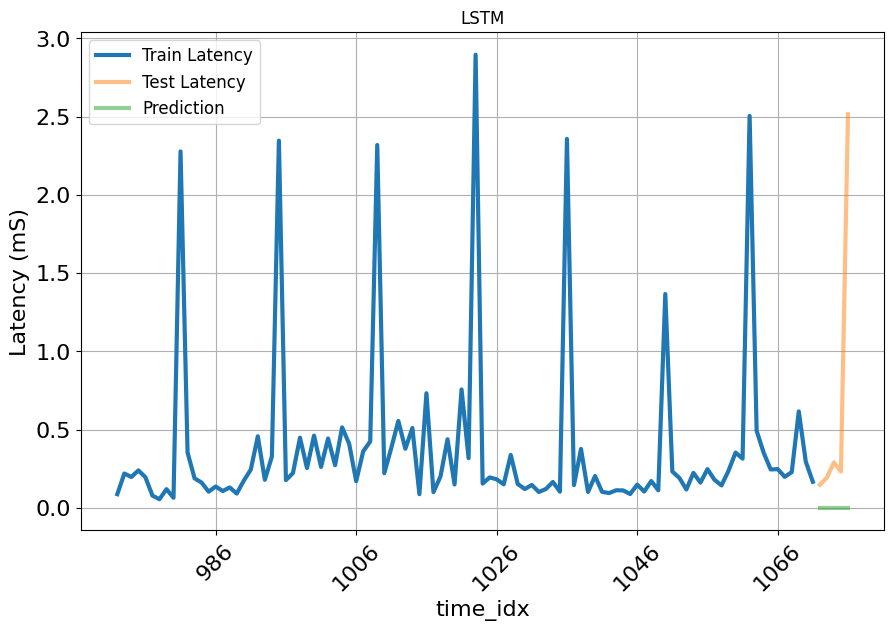

In [110]:
last_fold_train_path = os.path.join(DATASET_MAIN_DIR, f'multistep_train_{dataset_idx_list[-1]}.xlsx')
last_fold_train = pd.read_excel(last_fold_train_path)
multistep_last_fold_preds_df = pd.concat(multistep_last_fold_preds, axis=0)


for idx, grp in multistep_last_fold_preds_df.groupby('Model'):
    last_fold_train[last_fold_train['time_idx'] >= grp['ds'].min()-100].set_index('time_idx')['Latency'].plot(figsize=(9,6), label='Train Latency', title=idx, fontsize=16, lw=3)
    grp.set_index('ds')['y'].plot(label='Test Latency', lw=3, alpha=0.5)
    grp.set_index('ds')['Prediction'].plot(label='Prediction', lw=3, alpha=0.5)
    x_axis_values = pd.concat([last_fold_train[last_fold_train['time_idx'] >= cold_start_time_indices[0]-100]['time_idx'], grp['ds']], axis=0)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.xticks(x_axis_values.values[::20], rotation=45)
    plt.ylabel('Latency (mS)', fontsize=16)
    plt.xlabel('time_idx', fontsize=16)
    plt.grid()
    plt.autoscale(tight=False)
    plt.savefig(f'plots_azure_dataset/multistep_SARIMA_{idx}_plot.png')
    plt.show()

In [111]:
multistep_results = pd.DataFrame(multistep_model_metrics)
display(multistep_results)
display(multistep_results.groupby('Model')[['Fold_TrainTime', 'Fold_PredictTime', 'MAE', 'MAPE', 'RMSE', 'MSE']].mean())

,Fold,Fold_TrainTime,Fold_PredictTime,Model,MAE,MAPE,RMSE,MSE
0,1,42.9340174000,0.6495369000,LSTM,0.6756000000,1.0000000000,1.2024621408,1.4459152000
1,2,34.6471400000,0.6585856000,LSTM,0.6630000000,1.0000000000,1.2845530740,1.6500766000
2,3,35.3277895000,0.6310149000,LSTM,0.6666000000,1.0000000000,1.2185884457,1.4849578000
3,4,34.5662953000,0.6241552000,LSTM,0.6752000000,1.0000000000,1.1416635231,1.3033956000


,Fold_TrainTime,Fold_PredictTime,MAE,MAPE,RMSE,MSE
Model,,,,,,
LSTM,36.8688105500,0.6408231500,0.6701000000,1.0000000000,1.2118167959,1.4710863000


### SingleStep

In [ ]:
singlestep_last_fold_preds = []
singlestep_model_metrics = []
counter = 1
for dataset_id in dataset_idx_list:
    train_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_train_{dataset_id}.xlsx')
    test_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_test_{dataset_id}.xlsx')

    train = pd.read_excel(train_path)
    test = pd.read_excel(test_path)

    train = train.drop(['DateTime'], axis=1)
    test = test.drop(['DateTime'], axis=1)

    # future_exog_features = [c for c in train.columns if c not in [ID_COL, TIME_COL, TARGET, 'CPU_Usage', 'Memory_Usage']]
    # historical_exog_features = ['CPU_Usage', 'Memory_Usage']
    train = train.rename(columns={ID_COL: 'unique_id', TIME_COL: 'ds', TARGET: 'y'})
    test = test.rename(columns={ID_COL: 'unique_id', TIME_COL: 'ds', TARGET: 'y'})

    nf = NeuralForecast(
    models=[LSTM(h=1, input_size=-1,
                 loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                 scaler_type='robust',
                 encoder_n_layers=2,
                 encoder_hidden_size=128,
                 context_size=10,
                 decoder_hidden_size=128,
                 decoder_layers=2,
                 max_steps=500,
                #  futr_exog_list=future_exog_features,
                #  hist_exog_list=historical_exog_features,
                 )
    ],
    freq='m'
    )
    
    train[ID_COL] = train[ID_COL].astype(int)
    test[ID_COL] = test[ID_COL].astype(int)

    t1 = time.perf_counter()
    nf.fit(df=train)
    t2 = time.perf_counter()
    #print(f'Training Time For {model.__class__.__name__}:', t2-t1)
    preds = nf.predict(futr_df=test)
    t3 = time.perf_counter()
    # print(f'Prediction Time For {model.__class__.__name__}:', t3-t2)

    preds = preds.merge(test, on=['ds', 'unique_id'])
    metrics_dict = {}
    metrics_dict['Fold'] = counter
    metrics_dict['Fold_TrainTime'] = t2-t1
    metrics_dict['Fold_PredictTime'] = t3-t2
    # for estimator in models:
    estimator_name = 'LSTM'
    preds[estimator_name] = preds[estimator_name].astype(int)
    metrics_dict['Model'] = estimator_name
    metrics_dict[f'MAE'] = mean_absolute_error(y_true=preds['y'], y_pred=preds[estimator_name])
    metrics_dict[f'MAPE'] = mean_absolute_percentage_error(y_true=preds['y'], y_pred=preds[estimator_name])
    metrics_dict[f'RMSE'] = mean_squared_error(y_true=preds['y'], y_pred=preds[estimator_name], squared=False)
    metrics_dict[f'MSE'] = mean_squared_error(y_true=preds['y'], y_pred=preds[estimator_name], squared=True)
    singlestep_model_metrics.append(metrics_dict)

    if counter == 4:
        singlestep_last_fold_df = preds[[estimator_name, 'y', 'ds']].rename(columns={estimator_name: 'Prediction'})
        singlestep_last_fold_df['Model'] = estimator_name
        test = pd.read_excel(test_path).rename(columns={ID_COL: 'unique_id', TIME_COL: 'ds', TARGET: 'y'})
        singlestep_last_fold_df = singlestep_last_fold_df.merge(test[['DateTime', 'ds']], on='ds', how='left')
        singlestep_last_fold_preds.append(singlestep_last_fold_df)
    counter += 1

In [117]:
last_fold_train

,DateTime,Latency,unique_id,time_idx
0,505800.1994938850,0.1820000000,1,475
1,506100.5452051163,0.5060000000,1,476
2,506400.1484789848,0.1410000000,1,477
3,506700.6595020294,0.6630000000,1,478
4,506748.6346158981,2.8080000000,1,479
...,...,...,...,...
596,1169100.1737720971,0.1660000000,1,1071
597,1169400.1650109291,0.1470000000,1,1072
598,1169700.2073230741,0.1930000000,1,1073
599,1170000.3149530890,0.2900000000,1,1074


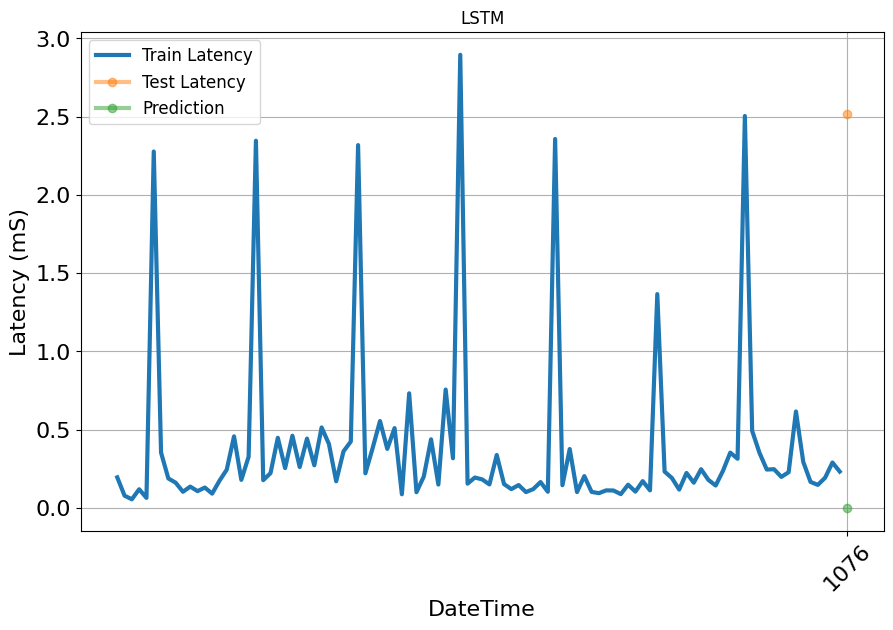

In [118]:
last_fold_train_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_train_{dataset_idx_list[-1]}.xlsx')
last_fold_train = pd.read_excel(last_fold_train_path)
singlestep_last_fold_preds_df = pd.concat(singlestep_last_fold_preds, axis=0)


for idx, grp in singlestep_last_fold_preds_df.groupby('Model'):
    # display(last_fold_train)
    # display(grp)
    last_fold_train[last_fold_train['time_idx'] >= grp['ds'].min()-100].set_index('time_idx')['Latency'].plot(figsize=(9,6), label='Train Latency', title=idx, fontsize=16, lw=3)
    grp.set_index('ds')['y'].plot(label='Test Latency', lw=3, alpha=0.5, marker='o')
    grp.set_index('ds')['Prediction'].plot(label='Prediction', lw=3, alpha=0.5, marker='o')
    x_axis_values = pd.concat([last_fold_train[last_fold_train['time_idx'] >= grp['ds'].min()-100]['DateTime'], grp['ds']], axis=0)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.xticks(x_axis_values.values[::2], rotation=45)
    plt.ylabel('Latency (mS)', fontsize=16)
    plt.xlabel('DateTime', fontsize=16)
    plt.grid()
    plt.autoscale(tight=False)
    plt.savefig(f'plots_azure_dataset/singlestep_LSTM_{idx}_plot.png')
    plt.show()

In [119]:
singlestep_results = pd.DataFrame(singlestep_model_metrics)
display(singlestep_results)
display(singlestep_results.groupby('Model')[['Fold_TrainTime', 'Fold_PredictTime', 'MAE', 'MAPE', 'RMSE', 'MSE']].mean())

,Fold,Fold_TrainTime,Fold_PredictTime,Model,MAE,MAPE,RMSE,MSE
0,1,38.4845290000,0.4782099000,LSTM,2.6570000000,1.0000000000,2.6570000000,7.0596490000
1,2,39.0980944000,0.4004721000,LSTM,2.8630000000,1.0000000000,2.8630000000,8.1967690000
2,3,40.3870193000,0.4466544000,LSTM,2.7000000000,1.0000000000,2.7000000000,7.2900000000
3,4,38.8513589000,0.3925680000,LSTM,2.5140000000,1.0000000000,2.5140000000,6.3201960000


,Fold_TrainTime,Fold_PredictTime,MAE,MAPE,RMSE,MSE
Model,,,,,,
LSTM,39.2052504000,0.4294761000,2.6835000000,1.0000000000,2.6835000000,7.2166535000


# All plot

In [129]:
filt_df = df[['DateTime', 'Latency', 'time_idx']]
filt_df = filt_df[filt_df['time_idx'] >= cold_start_time_indices[0] - 200]
#filt_df = filt_df[(filt_df['DateTime'].dt.day == 6) & (filt_df['DateTime'].dt.hour >= 11)]
filt_df

,DateTime,Latency,time_idx
981028,489900.1486809254,0.1330000000,446
981375,490200.2367320061,0.2280000000,447
981608,490500.2379128933,0.2270000000,448
982044,490800.2383470535,0.2140000000,449
982531,491100.1968379021,0.1760000000,450
...,...,...,...
1976296,1205400.1272449491,0.1180000000,1105
1976670,1205700.3708989620,0.3650000000,1106
1977115,1206000.0856299400,0.0790000000,1107
1977631,1206300.1464600563,0.1260000000,1108


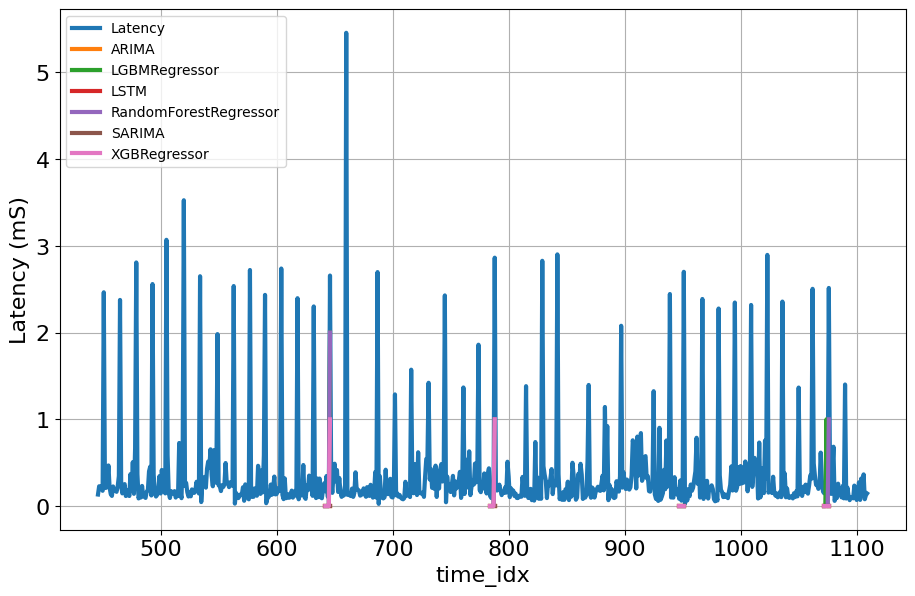

In [134]:
temp_df = pd.concat(all_multistep_results, axis=0)

filt_df.set_index('time_idx')['Latency'].plot(figsize=(9,6), label='Latency', fontsize=16, lw=3)
for idx, grp in temp_df.groupby('Model'):
    grp = grp.set_index('time_idx')
    grp = grp.reindex(filt_df.set_index('time_idx').index, fill_value=np.nan)
    grp['Prediction'].plot(label=idx, lw=3, alpha=1)

plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
#plt.xticks(x_axis_values.values[::2], labels=x_axis_values.dt.strftime('%H:%M').values[::2], rotation=45)
plt.ylabel('Latency (mS)', fontsize=16)
plt.xlabel('time_idx', fontsize=16)
plt.grid()
plt.autoscale(tight=False)
plt.savefig(f'plots_new/multistep_all_models_plot_2.png')
plt.show()